In [1]:
# !pip install seaborn openpyxl

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import warnings 
import time
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

# Membaca data dari file CSV
X_train = pd.read_csv('/kaggle/input/dataset-sarah/X_train.csv', sep=';')
X_test = pd.read_csv('/kaggle/input/dataset-sarah/X_test.csv', sep=';')
y_train = pd.read_csv('/kaggle/input/dataset-sarah/y_train.csv')
y_test = pd.read_csv('/kaggle/input/dataset-sarah/y_test.csv')

# Menghitung jumlah data untuk setiap variabel di X_train
print("Jumlah data untuk setiap variabel di X_train:")
print(X_train.count())

# Menghitung jumlah data untuk setiap variabel di X_test
print("\nJumlah data untuk setiap variabel di X_test:")
print(X_test.count())

# Menghitung jumlah data untuk setiap variabel di y_train
print("\nJumlah data untuk setiap variabel di y_train:")
print(y_train.count())

# Menghitung jumlah data untuk setiap variabel di y_test
print("\nJumlah data untuk setiap variabel di y_test:")
print(y_test.count())

Jumlah data untuk setiap variabel di X_train:
duration                       394045
protocol_type                  394045
service                        394045
flag                           394045
src_bytes                      394045
dst_bytes                      394045
land                           394045
wrong_fragment                 394045
urgent                         394045
hot                            394045
num_failed_logins              394045
logged_in                      394045
lnum_compromised               394045
lroot_shell                    394045
lsu_attempted                  394045
lnum_root                      394045
lnum_file_creations            394045
lnum_shells                    394045
lnum_access_files              394045
lnum_outbound_cmds             394045
is_host_login                  394045
is_guest_login                 394045
count                          394045
srv_count                      394045
serror_rate                    394045
srv_

In [4]:
# Menentukan ukuran sampel (misalnya 10% dari total data)
sample_fraction = 0.005

# Mengambil sampel dari dataset
X_train_sample = X_train.sample(frac=sample_fraction, random_state=42)
X_test_sample = X_test.sample(frac=sample_fraction, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]
y_test_sample = y_test.loc[X_test_sample.index]

# Menampilkan jumlah data setelah sampling
print(f"Jumlah data training setelah sampling: {len(X_train_sample)}")
print(f"Jumlah data testing setelah sampling: {len(X_test_sample)}")

Jumlah data training setelah sampling: 1970
Jumlah data testing setelah sampling: 493


In [5]:
class KNNClassifier:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X_train, y_train):
        self.df_train = pd.concat([X_train, y_train], axis=1)
        self.np_X_train = np.array(self.df_train)

    def euclidean_distance(self, point1, point2):
        sum_squared_distance = 0
        for i in range(len(point1) - 1):
            sum_squared_distance += math.pow(point1[i] - point2[i], 2)
        return math.sqrt(sum_squared_distance)

    def vote(self, neighbors):
        class_counter = {}
        for neighbor in neighbors:
            if neighbor[0][-1] in class_counter: 
                class_counter[neighbor[0][-1]] += 1
            else:
                class_counter[neighbor[0][-1]] = 1
        sorted_votes = sorted(class_counter.items(), key=lambda x: x[1], reverse=True)
        return sorted_votes, sorted_votes[0][0]

    def predict(self, X_test, y_test):
        df_test = pd.concat([X_test, y_test], axis=1)
        np_X_test = np.array(df_test)
        predictions = []
        true_labels = []
        results = []

        for i in range(len(np_X_test)):
            distances = []
            for index in range(len(self.np_X_train)):
                dist = self.euclidean_distance(np_X_test[i], self.np_X_train[index])
                distances.append((self.np_X_train[index], dist))
            distances.sort(key=lambda x: x[1])
            neighbors = distances[:self.k]
            sorted_votes, prediction = self.vote(neighbors)
            result = {
                "Data ke": i+1,
                "Data test": np_X_test[i],
                "Data train": neighbors,
                "Jarak": sorted_votes,
                "Prediksi": prediction
            }
            results.append(result)
            predictions.append(prediction)
            true_labels.append(np_X_test[i][-1])

        df_result = pd.DataFrame(results)
        df_result.set_index('Data ke', inplace=True)
        return df_result, np.array(predictions), np.array(true_labels)

def evaluate_knn(k, X_train, X_test, y_train, y_test):
    knn = KNNClassifier(k=k)
    knn.fit(X_train, y_train)
    
    start_time = time.time()
    df_result, y_pred, y_true = knn.predict(X_test, y_test)
    training_time = time.time() - start_time

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    
    # Display confusion matrix as a heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test.values.ravel()), yticklabels=set(y_test.values.ravel()))
    plt.title(f'Confusion Matrix for KNN with k={k}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print(f"Results for KNN with k={k}:")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(cr)
    print("-" * 60)
    
    # Identify misclassified samples
    misclassified = X_test[y_test.values.ravel() != y_pred]
    misclassified['True Label'] = y_test[y_test.values.ravel() != y_pred].values
    misclassified['Predicted Label'] = y_pred[y_test.values.ravel() != y_pred]
    
    # Export misclassified samples to Excel
    misclassified.to_excel(f'misclassified_k{k}.xlsx', index=False)
    print(f'Misclassified samples for k={k} have been saved to misclassified_k{k}.xlsx')

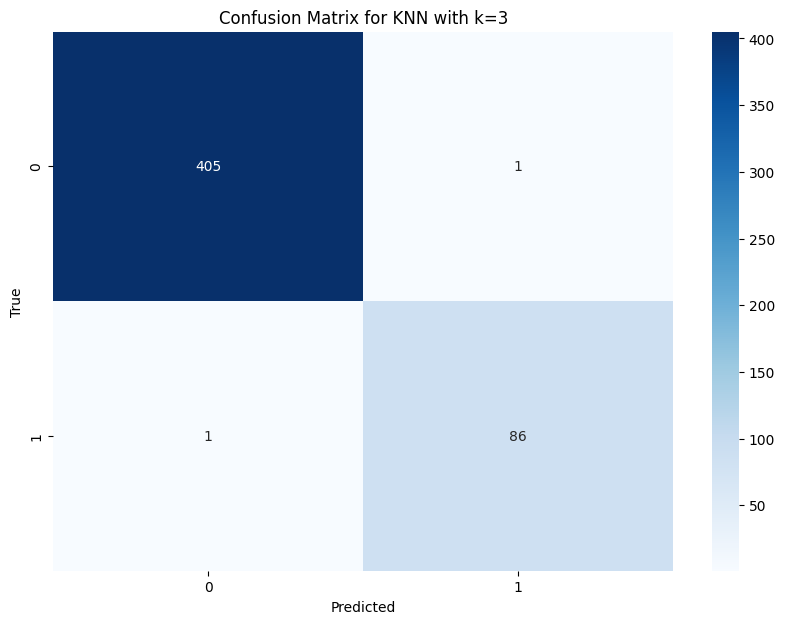

Results for KNN with k=3:
Training Time: 30.4213 seconds
Accuracy: 0.9959
Precision: 0.9959
Recall: 0.9959
F1 Score: 0.9959
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       406
         1.0       0.99      0.99      0.99        87

    accuracy                           1.00       493
   macro avg       0.99      0.99      0.99       493
weighted avg       1.00      1.00      1.00       493

------------------------------------------------------------
Misclassified samples for k=3 have been saved to misclassified_k3.xlsx


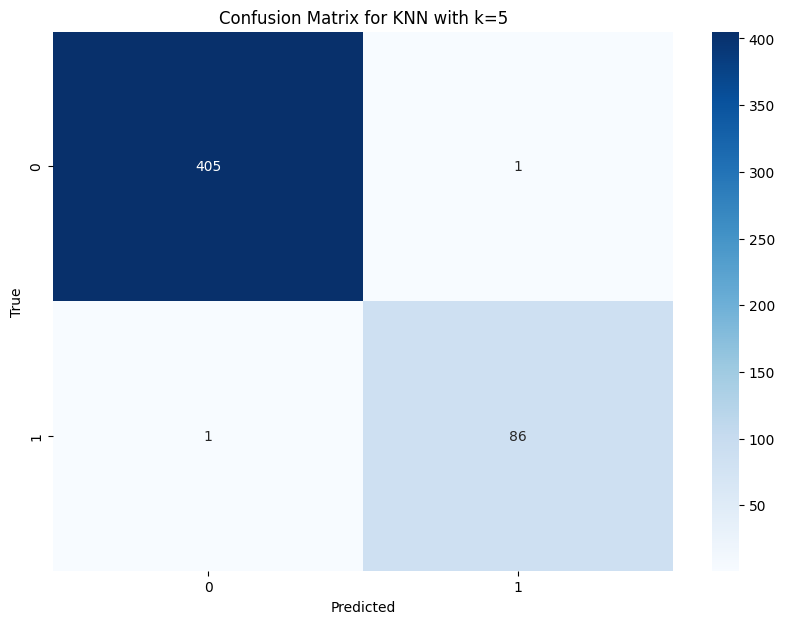

Results for KNN with k=5:
Training Time: 30.2580 seconds
Accuracy: 0.9959
Precision: 0.9959
Recall: 0.9959
F1 Score: 0.9959
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       406
         1.0       0.99      0.99      0.99        87

    accuracy                           1.00       493
   macro avg       0.99      0.99      0.99       493
weighted avg       1.00      1.00      1.00       493

------------------------------------------------------------
Misclassified samples for k=5 have been saved to misclassified_k5.xlsx


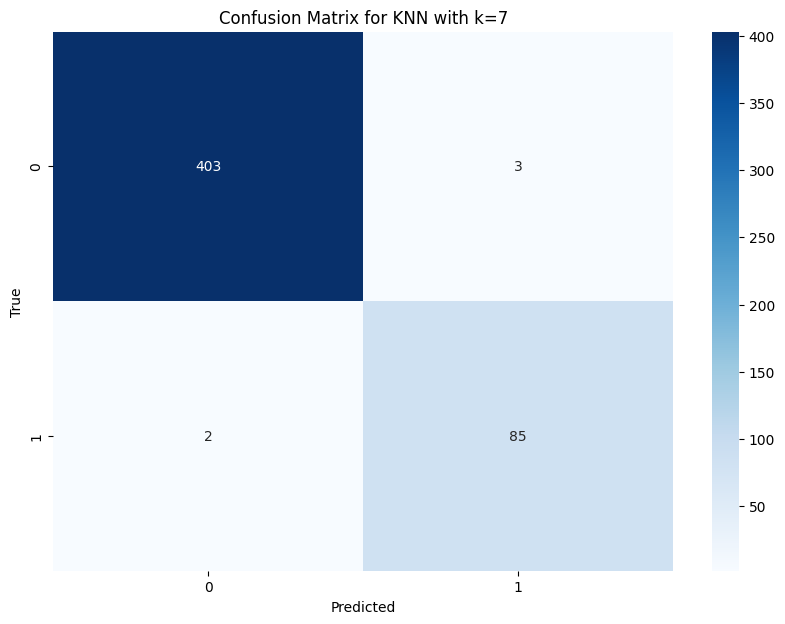

Results for KNN with k=7:
Training Time: 30.2501 seconds
Accuracy: 0.9899
Precision: 0.9899
Recall: 0.9899
F1 Score: 0.9899
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       406
         1.0       0.97      0.98      0.97        87

    accuracy                           0.99       493
   macro avg       0.98      0.98      0.98       493
weighted avg       0.99      0.99      0.99       493

------------------------------------------------------------
Misclassified samples for k=7 have been saved to misclassified_k7.xlsx


In [6]:
# Evaluate for K = 3, 5, and 7
for k in [3, 5, 7]:
    evaluate_knn(k, X_train_sample, X_test_sample, y_train_sample, y_test_sample)